### Árbol de Decisión para Regresión
#### Este notebook implementa un modelo de Árbol de Decisión para predecir la popularidad de canciones de Spotify.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import (
    cross_val_score, GridSearchCV, train_test_split, 
    RepeatedKFold, cross_validate, KFold
)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import warnings
warnings.filterwarnings('ignore')

print("✅ Librerías importadas correctamente")


✅ Librerías importadas correctamente


In [2]:
# Importar dependencias necesarias
from pathlib import Path
import pandas as pd

# Configurar rutas (robusto para cualquier subdirectorio dentro de notebooks)
current = Path.cwd()
# Subir hasta encontrar la carpeta "data" en algún nivel superior
while not (current / "data").exists() and current.parent != current:
    current = current.parent

PROJ = current
DATA = PROJ / "data"

# Verificar que existe la carpeta data
assert DATA.exists(), f"No se encontró la carpeta 'data'. Directorio actual: {Path.cwd()}"

# Cargar datasets con feature engineering aplicado
train = pd.read_csv(DATA / "train_fe.csv")
test = pd.read_csv(DATA / "test_fe.csv")

print(f"✅ Datos cargados correctamente")
print(f"📊 Ruta del proyecto: {PROJ}")
print(f"📊 Shape de train: {train.shape}")
print(f"📊 Shape de test: {test.shape}")
print(f"\nColumnas en train: {train.columns.tolist()}")

✅ Datos cargados correctamente
📊 Ruta del proyecto: c:\Users\alfon\Escritorio\Licenciatura en Sistemas\Machine Learning\Obligatorio
📊 Shape de train: (79800, 17)
📊 Shape de test: (34200, 17)

Columnas en train: ['track_id', 'popularity', 'explicit', 'danceability', 'energy', 'loudness', 'speechiness', 'instrumentalness', 'valence', 'tempo', 'time_signature', 'artist_count', 'album_mean_popularity', 'track_name_len', 'track_has_remix', 'track_has_acoustic', 'genre_mean_popularity']


In [3]:
# Separar features y target
X_train = train.drop(columns=['track_id', 'popularity'])
y_train = train['popularity']

# Preparar test: eliminar track_id e id (test_fe.csv tiene una columna 'id' que no está en train)
X_test = test.drop(columns=['track_id', 'id'], errors='ignore')

# Verificar que las columnas coincidan con las de entrenamiento
if set(X_test.columns) != set(X_train.columns):
    print("⚠️ Advertencia: Las columnas no coinciden completamente")
    print(f"  Columnas en train pero no en test: {set(X_train.columns) - set(X_test.columns)}")
    print(f"  Columnas en test pero no en train: {set(X_test.columns) - set(X_train.columns)}")
    # Asegurar que X_test tenga las mismas columnas que X_train en el mismo orden
    X_test = X_test[[col for col in X_train.columns if col in X_test.columns]]

print(f"✅ Datos preparados")
print(f"📊 X_train shape: {X_train.shape}")
print(f"📊 X_test shape: {X_test.shape}")
print(f"📊 Columnas coinciden: {list(X_train.columns) == list(X_test.columns)}")

✅ Datos preparados
📊 X_train shape: (79800, 15)
📊 X_test shape: (34200, 15)
📊 Columnas coinciden: True


In [4]:
# Separar datos en train y validation usando Holdout (80-20)
X_train_holdout, X_val_holdout, y_train_holdout, y_val_holdout = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, shuffle=True
)

print(f"Train Holdout: {X_train_holdout.shape[0]} muestras")
print(f"Validation Holdout: {X_val_holdout.shape[0]} muestras")
print(f"Test: {X_test.shape[0]} muestras")


Train Holdout: 63840 muestras
Validation Holdout: 15960 muestras
Test: 34200 muestras


In [22]:
# Función auxiliar para calcular todas las métricas
def calcular_metricas(y_true, y_pred):
    """Calcula RMSE, MSE, MAE y R²"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {
        'RMSE': rmse,
        'MSE': mse,
        'MAE': mae,
        'R²': r2
    }

# Función para evaluar modelo con diferentes técnicas de validación
def evaluar_modelo_completo(modelo, X_train_data, y_train_data, X_val_data=None, y_val_data=None):
    """
    Evalúa un modelo usando diferentes técnicas de validación:
    - Cross-Validation (5-fold)
    - Repeated Holdout (5 repeticiones)
    - Holdout simple (si se proporcionan datos de validación)
    """
    resultados = {}
    
    # 1. Cross-Validation (5-fold)
    cv_scores = cross_validate(
        modelo, X_train_data, y_train_data,
        cv=5,
        scoring={
            'neg_mse': 'neg_mean_squared_error',
            'neg_mae': 'neg_mean_absolute_error',
            'r2': 'r2'
        },
        return_train_score=False,
        n_jobs=-1
    )
    
    resultados['CV'] = {
        'RMSE': np.sqrt(-cv_scores['test_neg_mse']).mean(),
        'RMSE_std': np.sqrt(-cv_scores['test_neg_mse']).std(),
        'MSE': -cv_scores['test_neg_mse'].mean(),
        'MSE_std': cv_scores['test_neg_mse'].std(),
        'MAE': -cv_scores['test_neg_mae'].mean(),
        'MAE_std': cv_scores['test_neg_mae'].std(),
        'R²': cv_scores['test_r2'].mean(),
        'R²_std': cv_scores['test_r2'].std()
    }
    
    # 2. Repeated Holdout (5 repeticiones)
    repeated_holdout_scores = {
        'RMSE': [],
        'MSE': [],
        'MAE': [],
        'R²': []
    }
    
    for seed in range(42, 47):  # 5 repeticiones con diferentes seeds
        X_tr, X_vl, y_tr, y_vl = train_test_split(
            X_train_data, y_train_data, test_size=0.2, random_state=seed, shuffle=True
        )
        modelo_temp = DecisionTreeRegressor(**modelo.get_params())
        modelo_temp.fit(X_tr, y_tr)
        y_pred_vl = modelo_temp.predict(X_vl)
        metricas = calcular_metricas(y_vl, y_pred_vl)
        repeated_holdout_scores['RMSE'].append(metricas['RMSE'])
        repeated_holdout_scores['MSE'].append(metricas['MSE'])
        repeated_holdout_scores['MAE'].append(metricas['MAE'])
        repeated_holdout_scores['R²'].append(metricas['R²'])
    
    resultados['Repeated_Holdout'] = {
        'RMSE': np.mean(repeated_holdout_scores['RMSE']),
        'RMSE_std': np.std(repeated_holdout_scores['RMSE']),
        'MSE': np.mean(repeated_holdout_scores['MSE']),
        'MSE_std': np.std(repeated_holdout_scores['MSE']),
        'MAE': np.mean(repeated_holdout_scores['MAE']),
        'MAE_std': np.std(repeated_holdout_scores['MAE']),
        'R²': np.mean(repeated_holdout_scores['R²']),
        'R²_std': np.std(repeated_holdout_scores['R²'])
    }
    
    # 3. Holdout simple (si se proporcionan datos de validación)
    if X_val_data is not None and y_val_data is not None:
        modelo.fit(X_train_data, y_train_data)
        y_pred_val = modelo.predict(X_val_data)
        resultados['Holdout'] = calcular_metricas(y_val_data, y_pred_val)
    
    return resultados

print("✅ Funciones de evaluación creadas")


✅ Funciones de evaluación creadas


In [23]:
# Definir diferentes configuraciones de hiperparámetros a evaluar
configuraciones = [
    {
        'nombre': 'Config 1: Profundidad limitada',
        'params': {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'random_state': 42}
    },
    {
        'nombre': 'Config 2: Profundidad media',
        'params': {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'random_state': 42}
    },
    {
        'nombre': 'Config 3: Profundidad alta',
        'params': {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'random_state': 42}
    },
    {
        'nombre': 'Config 4: Profundidad muy alta',
        'params': {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'random_state': 42}
    },
    {
        'nombre': 'Config 5: Sin límite de profundidad',
        'params': {'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'random_state': 42}
    },
    {
        'nombre': 'Config 6: Mayor regularización (min_samples_split)',
        'params': {'max_depth': 15, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': None, 'random_state': 42}
    },
    {
        'nombre': 'Config 7: Mayor regularización (min_samples_leaf)',
        'params': {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': None, 'random_state': 42}
    },
    {
        'nombre': 'Config 8: Regularización combinada',
        'params': {'max_depth': 15, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': None, 'random_state': 42}
    },
    {
        'nombre': 'Config 9: max_features sqrt',
        'params': {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'random_state': 42}
    },
    {
        'nombre': 'Config 10: max_features log2',
        'params': {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'random_state': 42}
    },
    {
        'nombre': 'Config 11: Profundidad 20 con regularización',
        'params': {'max_depth': 20, 'min_samples_split': 50, 'min_samples_leaf': 10, 'max_features': None, 'random_state': 42}
    },
    {
        'nombre': 'Config 12: Profundidad 25 con regularización',
        'params': {'max_depth': 25, 'min_samples_split': 30, 'min_samples_leaf': 5, 'max_features': None, 'random_state': 42}
    }
]

print(f"Total de configuraciones a evaluar: {len(configuraciones)}")


Total de configuraciones a evaluar: 12


In [24]:
# Verificar que todas las dependencias estén disponibles
try:
    from sklearn.tree import DecisionTreeRegressor
except ImportError:
    raise ImportError("Por favor ejecuta la celda 1 primero para importar las librerías necesarias")

# Verificar que las funciones estén definidas
if 'evaluar_modelo_completo' not in globals():
    raise NameError("Por favor ejecuta la celda 6 primero para definir la función 'evaluar_modelo_completo'")

# Verificar que las configuraciones estén definidas
if 'configuraciones' not in globals():
    raise NameError("Por favor ejecuta la celda 8 primero para definir 'configuraciones'")

# Verificar que los datos de holdout estén definidos
required_vars = ['X_train_holdout', 'y_train_holdout', 'X_val_holdout', 'y_val_holdout']
missing_vars = [var for var in required_vars if var not in globals()]
if missing_vars:
    raise NameError(f"Por favor ejecuta la celda 5 primero. Variables faltantes: {missing_vars}")

# Evaluar todas las configuraciones
resultados_experimentos = []

print("Evaluando configuraciones...")
print("=" * 80)

for i, config in enumerate(configuraciones, 1):
    print(f"\n[{i}/{len(configuraciones)}] Evaluando: {config['nombre']}")
    
    modelo = DecisionTreeRegressor(**config['params'])
    
    # Evaluar con diferentes técnicas de validación
    resultados = evaluar_modelo_completo(
        modelo, 
        X_train_holdout, 
        y_train_holdout,
        X_val_holdout,
        y_val_holdout
    )
    
    # Guardar resultados
    resultado_experimento = {
        'Configuración': config['nombre'],
        'max_depth': config['params']['max_depth'],
        'min_samples_split': config['params']['min_samples_split'],
        'min_samples_leaf': config['params']['min_samples_leaf'],
        'max_features': config['params']['max_features'],
        # Métricas Cross-Validation
        'CV_RMSE': resultados['CV']['RMSE'],
        'CV_RMSE_std': resultados['CV']['RMSE_std'],
        'CV_MSE': resultados['CV']['MSE'],
        'CV_MAE': resultados['CV']['MAE'],
        'CV_R²': resultados['CV']['R²'],
        # Métricas Repeated Holdout
        'RH_RMSE': resultados['Repeated_Holdout']['RMSE'],
        'RH_RMSE_std': resultados['Repeated_Holdout']['RMSE_std'],
        'RH_MSE': resultados['Repeated_Holdout']['MSE'],
        'RH_MAE': resultados['Repeated_Holdout']['MAE'],
        'RH_R²': resultados['Repeated_Holdout']['R²'],
        # Métricas Holdout simple
        'Holdout_RMSE': resultados['Holdout']['RMSE'],
        'Holdout_MSE': resultados['Holdout']['MSE'],
        'Holdout_MAE': resultados['Holdout']['MAE'],
        'Holdout_R²': resultados['Holdout']['R²']
    }
    
    resultados_experimentos.append(resultado_experimento)
    
    print(f"  CV RMSE: {resultados['CV']['RMSE']:.4f} (±{resultados['CV']['RMSE_std']:.4f})")
    print(f"  RH RMSE: {resultados['Repeated_Holdout']['RMSE']:.4f} (±{resultados['Repeated_Holdout']['RMSE_std']:.4f})")
    print(f"  Holdout RMSE: {resultados['Holdout']['RMSE']:.4f}")

print("\n" + "=" * 80)
print("✅ Evaluación completada")


Evaluando configuraciones...

[1/12] Evaluando: Config 1: Profundidad limitada
  CV RMSE: 7.6989 (±0.1180)
  RH RMSE: 7.6774 (±0.0612)
  Holdout RMSE: 7.7324

[2/12] Evaluando: Config 2: Profundidad media
  CV RMSE: 7.0625 (±0.1067)
  RH RMSE: 7.1332 (±0.0525)
  Holdout RMSE: 7.1346

[3/12] Evaluando: Config 3: Profundidad alta
  CV RMSE: 7.4498 (±0.1271)
  RH RMSE: 7.3974 (±0.0733)
  Holdout RMSE: 7.3974

[4/12] Evaluando: Config 4: Profundidad muy alta
  CV RMSE: 7.9958 (±0.0888)
  RH RMSE: 7.9237 (±0.0927)
  Holdout RMSE: 7.7750

[5/12] Evaluando: Config 5: Sin límite de profundidad
  CV RMSE: 8.2031 (±0.1342)
  RH RMSE: 8.1125 (±0.0665)
  Holdout RMSE: 8.0366

[6/12] Evaluando: Config 6: Mayor regularización (min_samples_split)
  CV RMSE: 7.1312 (±0.0806)
  RH RMSE: 7.0316 (±0.1241)
  Holdout RMSE: 7.0675

[7/12] Evaluando: Config 7: Mayor regularización (min_samples_leaf)
  CV RMSE: 6.9015 (±0.0831)
  RH RMSE: 6.8246 (±0.1095)
  Holdout RMSE: 6.8586

[8/12] Evaluando: Config 8: Re

In [25]:
# Crear DataFrame con todos los resultados
df_resultados = pd.DataFrame(resultados_experimentos)

# Tabla detallada con todas las métricas
print("\n" + "=" * 120)
print("TABLA 1: RESUMEN DE EXPERIMENTOS - ÁRBOL DE DECISIÓN")
print("=" * 120)

# Seleccionar columnas para mostrar
columnas_tabla = [
    'Configuración',
    'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features',
    'CV_RMSE', 'CV_RMSE_std', 'CV_MSE', 'CV_MAE', 'CV_R²',
    'RH_RMSE', 'RH_RMSE_std', 'RH_MSE', 'RH_MAE', 'RH_R²',
    'Holdout_RMSE', 'Holdout_MSE', 'Holdout_MAE', 'Holdout_R²'
]

tabla_detallada = df_resultados[columnas_tabla].copy()

# Formatear valores numéricos para mejor visualización
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 30)

print("\nTabla completa con todas las métricas:")
print(tabla_detallada.to_string(index=False))

# Guardar tabla en CSV
tabla_detallada.to_csv(DATA / 'resultados_arbol_decision_experimentos.csv', index=False)
print(f"\n✅ Tabla guardada en: {DATA / 'resultados_arbol_decision_experimentos.csv'}")



TABLA 1: RESUMEN DE EXPERIMENTOS - ÁRBOL DE DECISIÓN

Tabla completa con todas las métricas:
                                     Configuración  max_depth  min_samples_split  min_samples_leaf max_features   CV_RMSE  CV_RMSE_std     CV_MSE   CV_MAE    CV_R²  RH_RMSE  RH_RMSE_std    RH_MSE   RH_MAE    RH_R²  Holdout_RMSE  Holdout_MSE  Holdout_MAE  Holdout_R²
                    Config 1: Profundidad limitada        5.0                  2                 1         None  7.698934     0.117987  59.287511 4.969926 0.881355 7.677362     0.061233 58.945635 4.943920 0.881069      7.732422    59.790357     4.969355    0.879068
                       Config 2: Profundidad media       10.0                  2                 1         None  7.062537     0.106712  49.890821 4.117448 0.900159 7.133214     0.052531 50.885498 4.123671 0.897335      7.134562    50.901978     4.129413    0.897046
                        Config 3: Profundidad alta       15.0                  2                 1         N

In [26]:
# Tabla resumida más legible (solo métricas principales)
print("\n" + "=" * 120)
print("TABLA 2: RESUMEN SIMPLIFICADO - MÉTRICAS PRINCIPALES")
print("=" * 120)

columnas_resumen = [
    'Configuración',
    'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features',
    'CV_RMSE', 'CV_RMSE_std', 'CV_MAE', 'CV_R²',
    'RH_RMSE', 'RH_RMSE_std', 'RH_MAE', 'RH_R²',
    'Holdout_RMSE', 'Holdout_MAE', 'Holdout_R²'
]

tabla_resumen = df_resultados[columnas_resumen].copy()

# Formatear números con 4 decimales
for col in tabla_resumen.columns:
    if col != 'Configuración' and col != 'max_features':
        if 'std' in col:
            tabla_resumen[col] = tabla_resumen[col].apply(lambda x: f"±{x:.4f}")
        else:
            tabla_resumen[col] = tabla_resumen[col].apply(lambda x: f"{x:.4f}")

print("\nTabla resumida (métricas principales):")
print(tabla_resumen.to_string(index=False))



TABLA 2: RESUMEN SIMPLIFICADO - MÉTRICAS PRINCIPALES

Tabla resumida (métricas principales):
                                     Configuración max_depth min_samples_split min_samples_leaf max_features CV_RMSE CV_RMSE_std CV_MAE  CV_R² RH_RMSE RH_RMSE_std RH_MAE  RH_R² Holdout_RMSE Holdout_MAE Holdout_R²
                    Config 1: Profundidad limitada    5.0000            2.0000           1.0000         None  7.6989     ±0.1180 4.9699 0.8814  7.6774     ±0.0612 4.9439 0.8811       7.7324      4.9694     0.8791
                       Config 2: Profundidad media   10.0000            2.0000           1.0000         None  7.0625     ±0.1067 4.1174 0.9002  7.1332     ±0.0525 4.1237 0.8973       7.1346      4.1294     0.8970
                        Config 3: Profundidad alta   15.0000            2.0000           1.0000         None  7.4498     ±0.1271 3.9040 0.8889  7.3974     ±0.0733 3.8566 0.8896       7.3974      3.8156     0.8893
                    Config 4: Profundidad muy alta   2


ANÁLISIS DE RESULTADOS

🏆 MEJOR MODELO según Cross-Validation (menor RMSE):
   Configuración: Config 11: Profundidad 20 con regularización
   Hiperparámetros: max_depth=20.0, min_samples_split=50, min_samples_leaf=10, max_features=None
   CV RMSE: 6.8156 (±0.0724)
   CV MAE: 3.8021
   CV R²: 0.9070

🏆 MEJOR MODELO según Repeated Holdout (menor RMSE):
   Configuración: Config 11: Profundidad 20 con regularización
   Hiperparámetros: max_depth=20.0, min_samples_split=50, min_samples_leaf=10, max_features=None
   RH RMSE: 6.7382 (±0.0757)
   RH MAE: 3.7594
   RH R²: 0.9084

🏆 MEJOR MODELO según Holdout Simple (menor RMSE):
   Configuración: Config 11: Profundidad 20 con regularización
   Hiperparámetros: max_depth=20.0, min_samples_split=50, min_samples_leaf=10, max_features=None
   Holdout RMSE: 6.7401
   Holdout MAE: 3.7012
   Holdout R²: 0.9081

🏆 MEJOR MODELO según Cross-Validation (mayor R²):
   Configuración: Config 11: Profundidad 20 con regularización
   CV R²: 0.9070
   CV RMSE:

In [28]:
# Crear tabla con los mejores modelos
mejores_modelos = []

# Top 3 según CV RMSE
top3_cv_rmse = df_resultados.nsmallest(3, 'CV_RMSE')
for idx, row in top3_cv_rmse.iterrows():
    mejores_modelos.append({
        'Criterio': 'Top CV RMSE' if idx == top3_cv_rmse.index[0] else '',
        'Ranking': 1 if idx == top3_cv_rmse.index[0] else (2 if idx == top3_cv_rmse.index[1] else 3),
        'Configuración': row['Configuración'],
        'max_depth': row['max_depth'],
        'min_samples_split': row['min_samples_split'],
        'min_samples_leaf': row['min_samples_leaf'],
        'max_features': row['max_features'],
        'CV_RMSE': row['CV_RMSE'],
        'CV_RMSE_std': row['CV_RMSE_std'],
        'CV_MSE': row['CV_MSE'],
        'CV_MAE': row['CV_MAE'],
        'CV_R²': row['CV_R²'],
        'RH_RMSE': row['RH_RMSE'],
        'RH_RMSE_std': row['RH_RMSE_std'],
        'RH_MSE': row['RH_MSE'],
        'RH_MAE': row['RH_MAE'],
        'RH_R²': row['RH_R²'],
        'Holdout_RMSE': row['Holdout_RMSE'],
        'Holdout_MSE': row['Holdout_MSE'],
        'Holdout_MAE': row['Holdout_MAE'],
        'Holdout_R²': row['Holdout_R²']
    })

# Top 3 según RH RMSE
top3_rh_rmse = df_resultados.nsmallest(3, 'RH_RMSE')
for idx, row in top3_rh_rmse.iterrows():
    if idx not in top3_cv_rmse.index:  # Solo agregar si no está ya en la lista
        mejores_modelos.append({
            'Criterio': 'Top RH RMSE' if idx == top3_rh_rmse.index[0] else '',
            'Ranking': 1 if idx == top3_rh_rmse.index[0] else (2 if idx == top3_rh_rmse.index[1] else 3),
            'Configuración': row['Configuración'],
            'max_depth': row['max_depth'],
            'min_samples_split': row['min_samples_split'],
            'min_samples_leaf': row['min_samples_leaf'],
            'max_features': row['max_features'],
            'CV_RMSE': row['CV_RMSE'],
            'CV_RMSE_std': row['CV_RMSE_std'],
            'CV_MSE': row['CV_MSE'],
            'CV_MAE': row['CV_MAE'],
            'CV_R²': row['CV_R²'],
            'RH_RMSE': row['RH_RMSE'],
            'RH_RMSE_std': row['RH_RMSE_std'],
            'RH_MSE': row['RH_MSE'],
            'RH_MAE': row['RH_MAE'],
            'RH_R²': row['RH_R²'],
            'Holdout_RMSE': row['Holdout_RMSE'],
            'Holdout_MSE': row['Holdout_MSE'],
            'Holdout_MAE': row['Holdout_MAE'],
            'Holdout_R²': row['Holdout_R²']
        })

# Top 3 según CV R²
top3_cv_r2 = df_resultados.nlargest(3, 'CV_R²')
for idx, row in top3_cv_r2.iterrows():
    if idx not in top3_cv_rmse.index and idx not in top3_rh_rmse.index:
        mejores_modelos.append({
            'Criterio': 'Top CV R²' if idx == top3_cv_r2.index[0] else '',
            'Ranking': 1 if idx == top3_cv_r2.index[0] else (2 if idx == top3_cv_r2.index[1] else 3),
            'Configuración': row['Configuración'],
            'max_depth': row['max_depth'],
            'min_samples_split': row['min_samples_split'],
            'min_samples_leaf': row['min_samples_leaf'],
            'max_features': row['max_features'],
            'CV_RMSE': row['CV_RMSE'],
            'CV_RMSE_std': row['CV_RMSE_std'],
            'CV_MSE': row['CV_MSE'],
            'CV_MAE': row['CV_MAE'],
            'CV_R²': row['CV_R²'],
            'RH_RMSE': row['RH_RMSE'],
            'RH_RMSE_std': row['RH_RMSE_std'],
            'RH_MSE': row['RH_MSE'],
            'RH_MAE': row['RH_MAE'],
            'RH_R²': row['RH_R²'],
            'Holdout_RMSE': row['Holdout_RMSE'],
            'Holdout_MSE': row['Holdout_MSE'],
            'Holdout_MAE': row['Holdout_MAE'],
            'Holdout_R²': row['Holdout_R²']
        })

df_mejores = pd.DataFrame(mejores_modelos)

print("\n" + "=" * 120)
print("TABLA 3: MEJORES MODELOS - RESUMEN FINAL")
print("=" * 120)

# Mostrar tabla con mejores modelos
columnas_mejores = [
    'Criterio', 'Ranking', 'Configuración',
    'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features',
    'CV_RMSE', 'CV_RMSE_std', 'CV_MSE', 'CV_MAE', 'CV_R²',
    'RH_RMSE', 'RH_RMSE_std', 'RH_MSE', 'RH_MAE', 'RH_R²',
    'Holdout_RMSE', 'Holdout_MSE', 'Holdout_MAE', 'Holdout_R²'
]

tabla_mejores = df_mejores[columnas_mejores].copy()
print("\nTabla de mejores modelos:")
print(tabla_mejores.to_string(index=False))

# Guardar tabla
tabla_mejores.to_csv(DATA / 'mejores_modelos_arbol_decision.csv', index=False)
print(f"\n✅ Tabla de mejores modelos guardada en: {DATA / 'mejores_modelos_arbol_decision.csv'}")



TABLA 3: MEJORES MODELOS - RESUMEN FINAL

Tabla de mejores modelos:
   Criterio  Ranking                                     Configuración  max_depth  min_samples_split  min_samples_leaf max_features  CV_RMSE  CV_RMSE_std    CV_MSE   CV_MAE    CV_R²  RH_RMSE  RH_RMSE_std    RH_MSE   RH_MAE    RH_R²  Holdout_RMSE  Holdout_MSE  Holdout_MAE  Holdout_R²
Top CV RMSE        1      Config 11: Profundidad 20 con regularización       20.0                 50                10         None 6.815588     0.072379 46.457474 3.802096 0.907028 6.738186     0.075665 45.408877 3.759411 0.908387      6.740113    45.429124     3.701226    0.908115
                   2 Config 7: Mayor regularización (min_samples_leaf)       15.0                  2                10         None 6.901473     0.083074 47.637226 3.857690 0.904664 6.824641     0.109485 46.587715 3.802480 0.906010      6.858604    47.040453     3.782584    0.904856
                   3                Config 8: Regularización combinada       15

In [29]:
# Tabla resumida de mejores modelos (solo métricas principales)
print("\n" + "=" * 120)
print("TABLA 4: MEJORES MODELOS - RESUMEN SIMPLIFICADO")
print("=" * 120)

columnas_resumen_mejores = [
    'Criterio', 'Ranking', 'Configuración',
    'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features',
    'CV_RMSE', 'CV_RMSE_std', 'CV_MAE', 'CV_R²',
    'RH_RMSE', 'RH_RMSE_std', 'RH_MAE', 'RH_R²',
    'Holdout_RMSE', 'Holdout_MAE', 'Holdout_R²'
]

tabla_resumen_mejores = df_mejores[columnas_resumen_mejores].copy()

# Formatear números
for col in tabla_resumen_mejores.columns:
    if col not in ['Criterio', 'Ranking', 'Configuración', 'max_features']:
        if 'std' in col:
            tabla_resumen_mejores[col] = tabla_resumen_mejores[col].apply(lambda x: f"±{x:.4f}")
        else:
            tabla_resumen_mejores[col] = tabla_resumen_mejores[col].apply(lambda x: f"{x:.4f}")

print("\nTabla resumida de mejores modelos:")
print(tabla_resumen_mejores.to_string(index=False))



TABLA 4: MEJORES MODELOS - RESUMEN SIMPLIFICADO

Tabla resumida de mejores modelos:
   Criterio  Ranking                                     Configuración max_depth min_samples_split min_samples_leaf max_features CV_RMSE CV_RMSE_std CV_MAE  CV_R² RH_RMSE RH_RMSE_std RH_MAE  RH_R² Holdout_RMSE Holdout_MAE Holdout_R²
Top CV RMSE        1      Config 11: Profundidad 20 con regularización   20.0000           50.0000          10.0000         None  6.8156     ±0.0724 3.8021 0.9070  6.7382     ±0.0757 3.7594 0.9084       6.7401      3.7012     0.9081
                   2 Config 7: Mayor regularización (min_samples_leaf)   15.0000            2.0000          10.0000         None  6.9015     ±0.0831 3.8577 0.9047  6.8246     ±0.1095 3.8025 0.9060       6.8586      3.7826     0.9049
                   3                Config 8: Regularización combinada   15.0000           20.0000          10.0000         None  6.9015     ±0.0831 3.8577 0.9047  6.8246     ±0.1095 3.8025 0.9060       6.8586      3

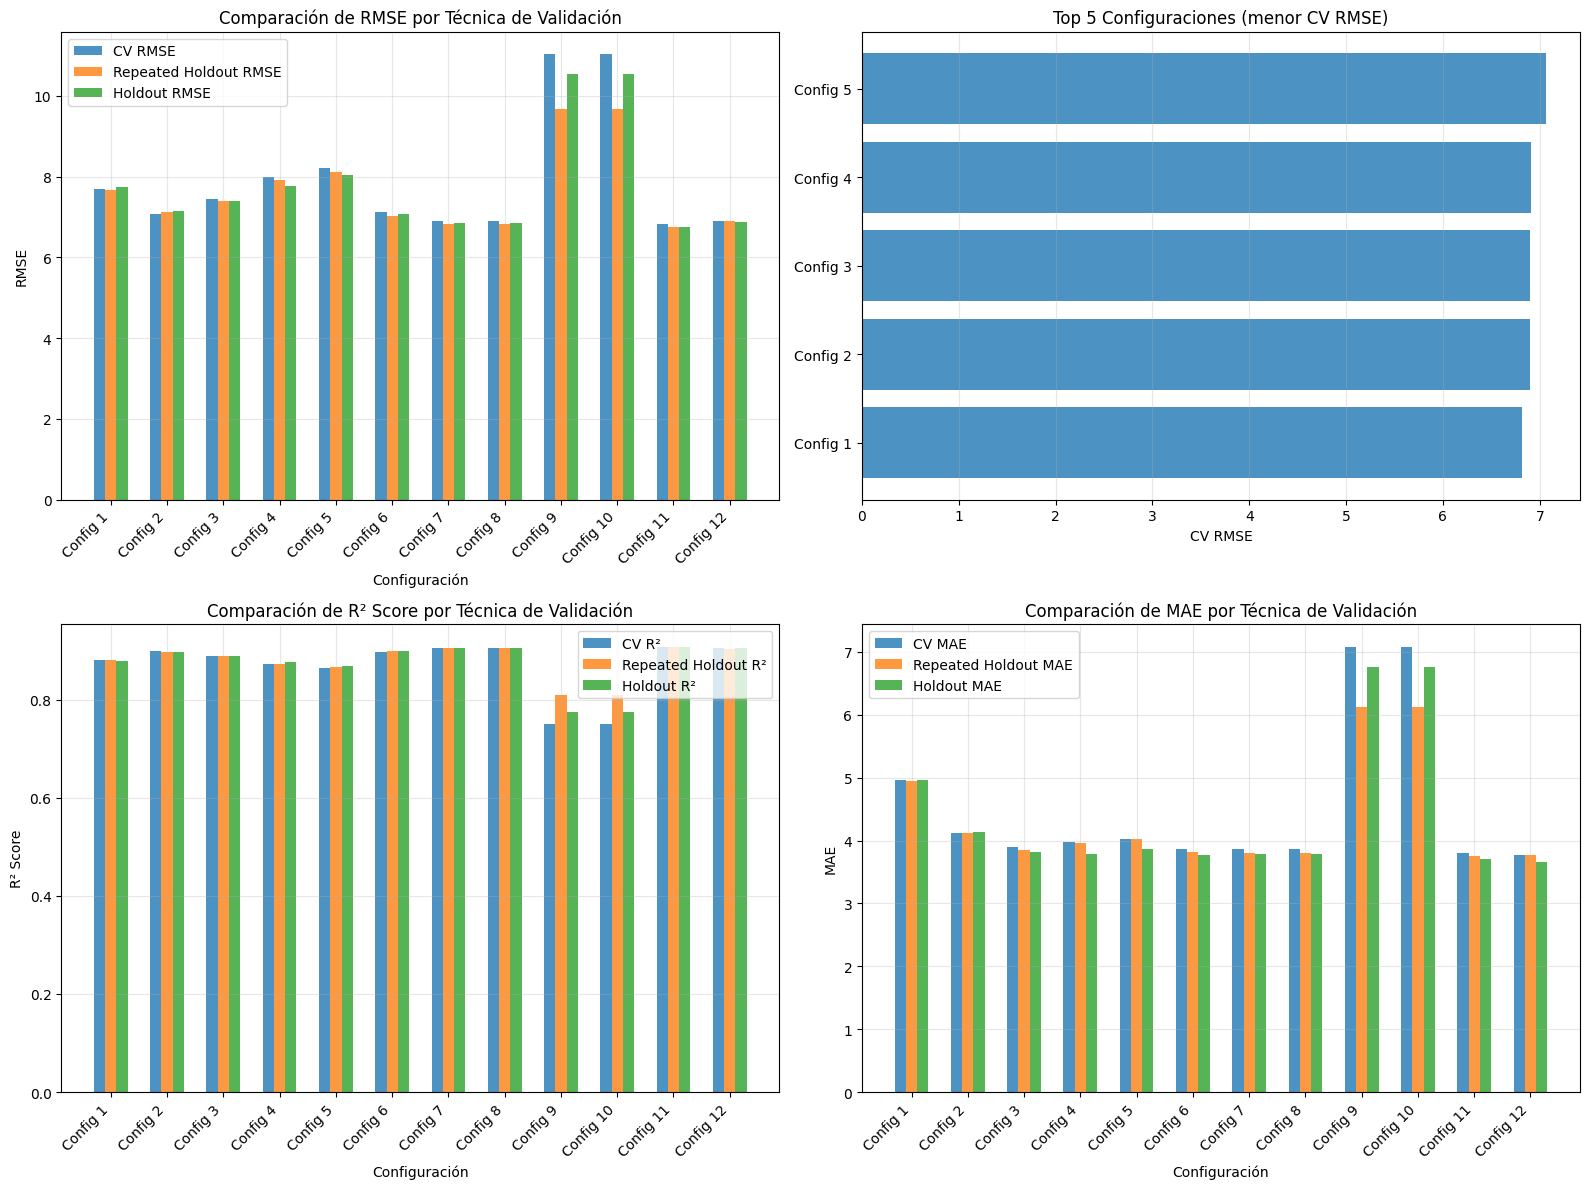

In [30]:
# Visualización comparativa de RMSE para diferentes configuraciones
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. RMSE por técnica de validación
ax1 = axes[0, 0]
x_pos = np.arange(len(df_resultados))
ax1.bar(x_pos - 0.2, df_resultados['CV_RMSE'], 0.2, label='CV RMSE', alpha=0.8)
ax1.bar(x_pos, df_resultados['RH_RMSE'], 0.2, label='Repeated Holdout RMSE', alpha=0.8)
ax1.bar(x_pos + 0.2, df_resultados['Holdout_RMSE'], 0.2, label='Holdout RMSE', alpha=0.8)
ax1.set_xlabel('Configuración')
ax1.set_ylabel('RMSE')
ax1.set_title('Comparación de RMSE por Técnica de Validación')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([f"Config {i+1}" for i in range(len(df_resultados))], rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Top 5 configuraciones según CV RMSE
ax2 = axes[0, 1]
top5_cv = df_resultados.nsmallest(5, 'CV_RMSE')
ax2.barh(range(len(top5_cv)), top5_cv['CV_RMSE'], alpha=0.8)
ax2.set_yticks(range(len(top5_cv)))
ax2.set_yticklabels([f"Config {i+1}" for i in range(len(top5_cv))])
ax2.set_xlabel('CV RMSE')
ax2.set_title('Top 5 Configuraciones (menor CV RMSE)')
ax2.grid(True, alpha=0.3, axis='x')

# 3. R² Score por técnica de validación
ax3 = axes[1, 0]
ax3.bar(x_pos - 0.2, df_resultados['CV_R²'], 0.2, label='CV R²', alpha=0.8)
ax3.bar(x_pos, df_resultados['RH_R²'], 0.2, label='Repeated Holdout R²', alpha=0.8)
ax3.bar(x_pos + 0.2, df_resultados['Holdout_R²'], 0.2, label='Holdout R²', alpha=0.8)
ax3.set_xlabel('Configuración')
ax3.set_ylabel('R² Score')
ax3.set_title('Comparación de R² Score por Técnica de Validación')
ax3.set_xticks(x_pos)
ax3.set_xticklabels([f"Config {i+1}" for i in range(len(df_resultados))], rotation=45, ha='right')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. MAE por técnica de validación
ax4 = axes[1, 1]
ax4.bar(x_pos - 0.2, df_resultados['CV_MAE'], 0.2, label='CV MAE', alpha=0.8)
ax4.bar(x_pos, df_resultados['RH_MAE'], 0.2, label='Repeated Holdout MAE', alpha=0.8)
ax4.bar(x_pos + 0.2, df_resultados['Holdout_MAE'], 0.2, label='Holdout MAE', alpha=0.8)
ax4.set_xlabel('Configuración')
ax4.set_ylabel('MAE')
ax4.set_title('Comparación de MAE por Técnica de Validación')
ax4.set_xticks(x_pos)
ax4.set_xticklabels([f"Config {i+1}" for i in range(len(df_resultados))], rotation=45, ha='right')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [31]:
print("\n" + "=" * 120)
print("CONCLUSIONES DE LA EVALUACIÓN")
print("=" * 120)

# Estadísticas generales
print("\n📊 ESTADÍSTICAS GENERALES:")
print(f"   - Total de configuraciones evaluadas: {len(df_resultados)}")
print(f"   - Rango de CV RMSE: {df_resultados['CV_RMSE'].min():.4f} - {df_resultados['CV_RMSE'].max():.4f}")
print(f"   - Rango de CV R²: {df_resultados['CV_R²'].min():.4f} - {df_resultados['CV_R²'].max():.4f}")
print(f"   - Media de CV RMSE: {df_resultados['CV_RMSE'].mean():.4f}")
print(f"   - Media de CV R²: {df_resultados['CV_R²'].mean():.4f}")

# Mejor configuración general
mejor_general_idx = df_resultados['CV_RMSE'].idxmin()
mejor_general = df_resultados.loc[mejor_general_idx]

print("\n🏆 MEJOR CONFIGURACIÓN GENERAL:")
print(f"   Nombre: {mejor_general['Configuración']}")
print(f"   Hiperparámetros:")
print(f"     - max_depth: {mejor_general['max_depth']}")
print(f"     - min_samples_split: {mejor_general['min_samples_split']}")
print(f"     - min_samples_leaf: {mejor_general['min_samples_leaf']}")
print(f"     - max_features: {mejor_general['max_features']}")
print(f"\n   Métricas:")
print(f"     - CV RMSE: {mejor_general['CV_RMSE']:.4f} (±{mejor_general['CV_RMSE_std']:.4f})")
print(f"     - CV MSE: {mejor_general['CV_MSE']:.4f}")
print(f"     - CV MAE: {mejor_general['CV_MAE']:.4f}")
print(f"     - CV R²: {mejor_general['CV_R²']:.4f}")
print(f"     - RH RMSE: {mejor_general['RH_RMSE']:.4f} (±{mejor_general['RH_RMSE_std']:.4f})")
print(f"     - Holdout RMSE: {mejor_general['Holdout_RMSE']:.4f}")

# Comparación entre técnicas de validación
print("\n📈 COMPARACIÓN ENTRE TÉCNICAS DE VALIDACIÓN:")
print(f"   CV RMSE promedio: {df_resultados['CV_RMSE'].mean():.4f} (±{df_resultados['CV_RMSE'].std():.4f})")
print(f"   RH RMSE promedio: {df_resultados['RH_RMSE'].mean():.4f} (±{df_resultados['RH_RMSE'].std():.4f})")
print(f"   Holdout RMSE promedio: {df_resultados['Holdout_RMSE'].mean():.4f} (±{df_resultados['Holdout_RMSE'].std():.4f})")

# Análisis de hiperparámetros
print("\n🔍 ANÁLISIS DE HIPERPARÁMETROS:")
print(f"   Mejor max_depth: {mejor_general['max_depth']}")
print(f"   Mejor min_samples_split: {mejor_general['min_samples_split']}")
print(f"   Mejor min_samples_leaf: {mejor_general['min_samples_leaf']}")
print(f"   Mejor max_features: {mejor_general['max_features']}")

print("\n" + "=" * 120)



CONCLUSIONES DE LA EVALUACIÓN

📊 ESTADÍSTICAS GENERALES:
   - Total de configuraciones evaluadas: 12
   - Rango de CV RMSE: 6.8156 - 11.0315
   - Rango de CV R²: 0.7511 - 0.9070
   - Media de CV RMSE: 7.9273
   - Media de CV R²: 0.8691

🏆 MEJOR CONFIGURACIÓN GENERAL:
   Nombre: Config 11: Profundidad 20 con regularización
   Hiperparámetros:
     - max_depth: 20.0
     - min_samples_split: 50
     - min_samples_leaf: 10
     - max_features: None

   Métricas:
     - CV RMSE: 6.8156 (±0.0724)
     - CV MSE: 46.4575
     - CV MAE: 3.8021
     - CV R²: 0.9070
     - RH RMSE: 6.7382 (±0.0757)
     - Holdout RMSE: 6.7401

📈 COMPARACIÓN ENTRE TÉCNICAS DE VALIDACIÓN:
   CV RMSE promedio: 7.9273 (±1.5196)
   RH RMSE promedio: 7.6597 (±1.0464)
   Holdout RMSE promedio: 7.7966 (±1.3509)

🔍 ANÁLISIS DE HIPERPARÁMETROS:
   Mejor max_depth: 20.0
   Mejor min_samples_split: 50
   Mejor min_samples_leaf: 10
   Mejor max_features: None



In [4]:
# Verificar si hay valores nulos
print(f"Valores nulos en X_train: {X_train.isnull().sum().sum()}")
print(f"Valores nulos en y_train: {y_train.isnull().sum()}")
print(f"Valores nulos en X_test: {X_test.isnull().sum().sum()}")

print(f"\nShape X_train: {X_train.shape}")
print(f"Shape y_train: {y_train.shape}")
print(f"Shape X_test: {X_test.shape}")

Valores nulos en X_train: 0
Valores nulos en y_train: 0
Valores nulos en X_test: 0

Shape X_train: (79800, 15)
Shape y_train: (79800,)
Shape X_test: (34200, 15)


### Modelo Base - Árbol de Decisión sin tunear
#### Primero entrenaremos un modelo base con parámetros por defecto para establecer un baseline.

In [32]:
# Entrenar modelo base con parámetros por defecto
dt_base = DecisionTreeRegressor(random_state=42)
dt_base.fit(X_train, y_train)

# Predicciones en train
y_train_pred_base = dt_base.predict(X_train)

# Métricas en train
mse_train_base = mean_squared_error(y_train, y_train_pred_base)
rmse_train_base = np.sqrt(mse_train_base)
mae_train_base = mean_absolute_error(y_train, y_train_pred_base)
r2_train_base = r2_score(y_train, y_train_pred_base)

print("=" * 60)
print("MODELO BASE - Métricas en TRAIN")
print("=" * 60)
print(f"MSE:  {mse_train_base:.4f}")
print(f"RMSE: {rmse_train_base:.4f}")
print(f"MAE:  {mae_train_base:.4f}")
print(f"R²:   {r2_train_base:.4f}")
print(f"\nProfundidad del árbol: {dt_base.get_depth()}")
print(f"Número de hojas: {dt_base.get_n_leaves()}")

MODELO BASE - Métricas en TRAIN
MSE:  0.1003
RMSE: 0.3168
MAE:  0.0102
R²:   0.9998

Profundidad del árbol: 44
Número de hojas: 33804


In [33]:
# Validación cruzada para evaluar generalización
cv_scores_base = cross_val_score(dt_base, X_train, y_train, 
                                  cv=5, 
                                  scoring='neg_mean_squared_error')

rmse_cv_base = np.sqrt(-cv_scores_base)

print("=" * 60)
print("MODELO BASE - Validación Cruzada (5-fold)")
print("=" * 60)
print(f"RMSE por fold: {rmse_cv_base}")
print(f"RMSE medio: {rmse_cv_base.mean():.4f} (+/- {rmse_cv_base.std():.4f})")

MODELO BASE - Validación Cruzada (5-fold)
RMSE por fold: [8.07898819 8.15417021 7.94902206 8.08575107 7.89468687]
RMSE medio: 8.0325 (+/- 0.0957)


In [34]:
# ## Optimización de Hiperparámetros con GridSearchCV
# Vamos a tunear los siguientes hiperparámetros:
# - **max_depth**: Profundidad máxima del árbol
# - **min_samples_split**: Mínimo de muestras para dividir un nodo
# - **min_samples_leaf**: Mínimo de muestras en una hoja
# - **max_features**: Número de features a considerar en cada split

# Cell 9: GridSearchCV
# Definir grilla de hiperparámetros
param_grid = {
    'max_depth': [5, 10, 15, 20, 25, None],
    'min_samples_split': [2, 10, 20, 50],
    'min_samples_leaf': [1, 5, 10, 20],
    'max_features': ['sqrt', 'log2', None]
}

print("Iniciando búsqueda de hiperparámetros...")
print(f"Combinaciones a probar: {len(param_grid['max_depth']) * len(param_grid['min_samples_split']) * len(param_grid['min_samples_leaf']) * len(param_grid['max_features'])}")

Iniciando búsqueda de hiperparámetros...
Combinaciones a probar: 288


In [35]:
# GridSearchCV con validación cruzada
grid_search = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("\n✅ Búsqueda completada")
print(f"\nMejores hiperparámetros encontrados:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nMejor RMSE en CV: {np.sqrt(-grid_search.best_score_):.4f}")

Fitting 5 folds for each of 288 candidates, totalling 1440 fits

✅ Búsqueda completada

Mejores hiperparámetros encontrados:
  max_depth: 20
  max_features: None
  min_samples_leaf: 10
  min_samples_split: 50

Mejor RMSE en CV: 6.7290


In [36]:
# Obtener el mejor modelo
dt_optimized = grid_search.best_estimator_

# Predicciones en train
y_train_pred_opt = dt_optimized.predict(X_train)

# Métricas en train
mse_train_opt = mean_squared_error(y_train, y_train_pred_opt)
rmse_train_opt = np.sqrt(mse_train_opt)
mae_train_opt = mean_absolute_error(y_train, y_train_pred_opt)
r2_train_opt = r2_score(y_train, y_train_pred_opt)

print("=" * 60)
print("MODELO OPTIMIZADO - Métricas en TRAIN")
print("=" * 60)
print(f"MSE:  {mse_train_opt:.4f}")
print(f"RMSE: {rmse_train_opt:.4f}")
print(f"MAE:  {mae_train_opt:.4f}")
print(f"R²:   {r2_train_opt:.4f}")
print(f"\nProfundidad del árbol: {dt_optimized.get_depth()}")
print(f"Número de hojas: {dt_optimized.get_n_leaves()}")

MODELO OPTIMIZADO - Métricas en TRAIN
MSE:  30.6779
RMSE: 5.5388
MAE:  2.9946
R²:   0.9385

Profundidad del árbol: 20
Número de hojas: 2246


In [37]:
# Comparar modelo base vs optimizado
comparison_df = pd.DataFrame({
    'Modelo': ['Base (sin tunear)', 'Optimizado (GridSearchCV)'],
    'RMSE Train': [rmse_train_base, rmse_train_opt],
    'RMSE CV': [rmse_cv_base.mean(), np.sqrt(-grid_search.best_score_)],
    'R² Train': [r2_train_base, r2_train_opt],
    'Profundidad': [dt_base.get_depth(), dt_optimized.get_depth()],
    'Número de Hojas': [dt_base.get_n_leaves(), dt_optimized.get_n_leaves()]
})

print("\n" + "=" * 80)
print("COMPARACIÓN DE MODELOS")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("\n✅ El modelo optimizado tiene mejor generalización (menor diferencia Train-CV)")


COMPARACIÓN DE MODELOS
                   Modelo  RMSE Train  RMSE CV  R² Train  Profundidad  Número de Hojas
        Base (sin tunear)    0.316772 8.032524  0.999799           44            33804
Optimizado (GridSearchCV)    5.538765 6.728962  0.938479           20             2246

✅ El modelo optimizado tiene mejor generalización (menor diferencia Train-CV)



Top 10 Features más importantes:
              feature  importance
album_mean_popularity    0.935826
genre_mean_popularity    0.033495
         artist_count    0.012625
     instrumentalness    0.004464
             loudness    0.002388
         danceability    0.002327
              valence    0.002240
               energy    0.001848
          speechiness    0.001628
       track_name_len    0.001477


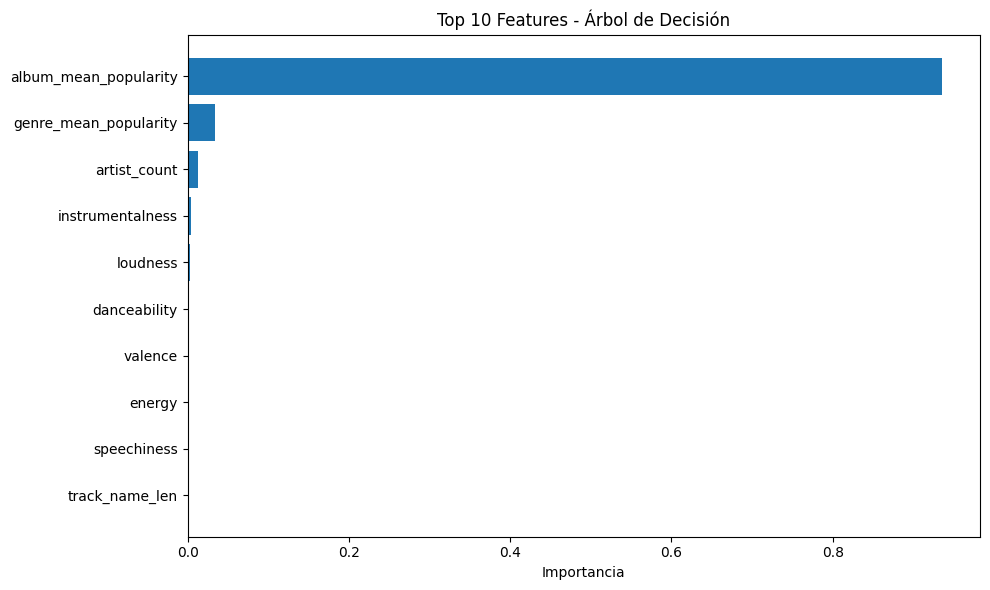

In [38]:
# Obtener importancia de features
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': dt_optimized.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Features más importantes:")
print(feature_importance.head(10).to_string(index=False))

# Visualizar
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'].head(10), 
         feature_importance['importance'].head(10))
plt.xlabel('Importancia')
plt.title('Top 10 Features - Árbol de Decisión')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

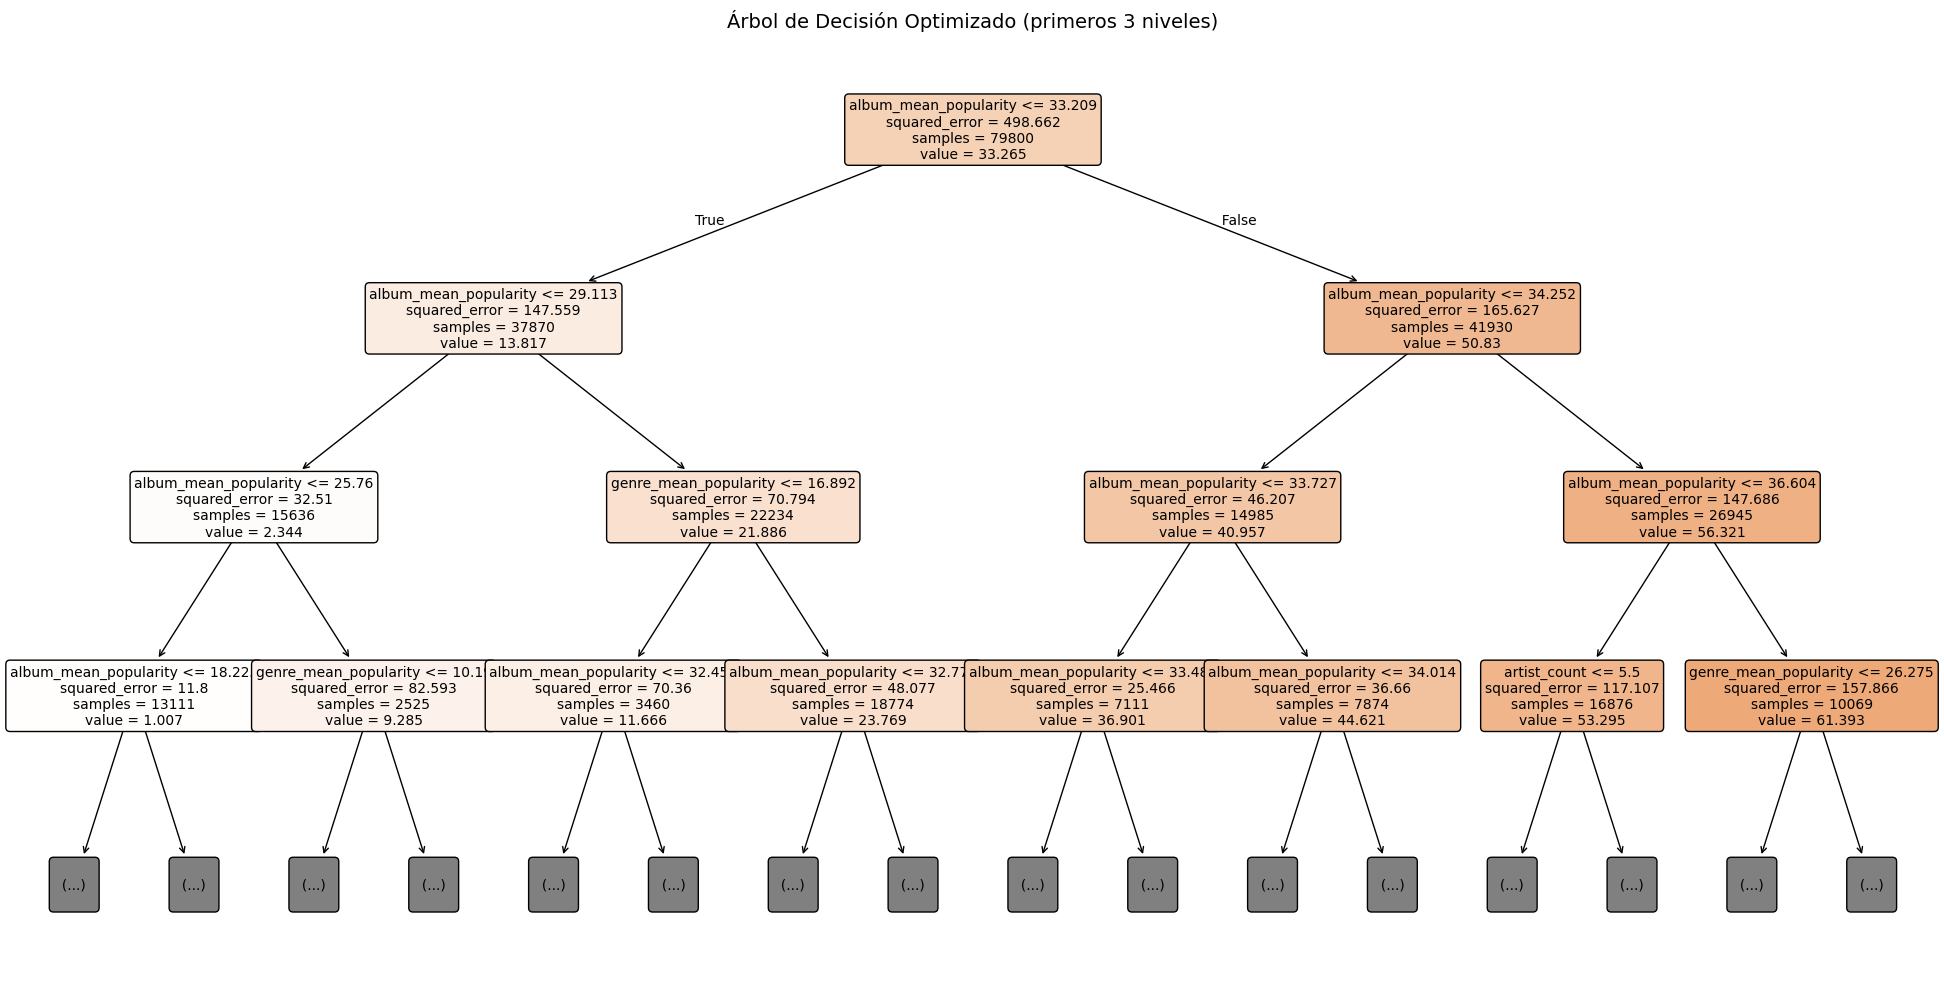

In [39]:
# Visualizar los primeros 3 niveles del árbol optimizado
plt.figure(figsize=(20, 10))
plot_tree(dt_optimized, 
          max_depth=3,
          feature_names=X_train.columns,
          filled=True,
          fontsize=10,
          rounded=True)
plt.title('Árbol de Decisión Optimizado (primeros 3 niveles)', fontsize=14)
plt.tight_layout()
plt.show()

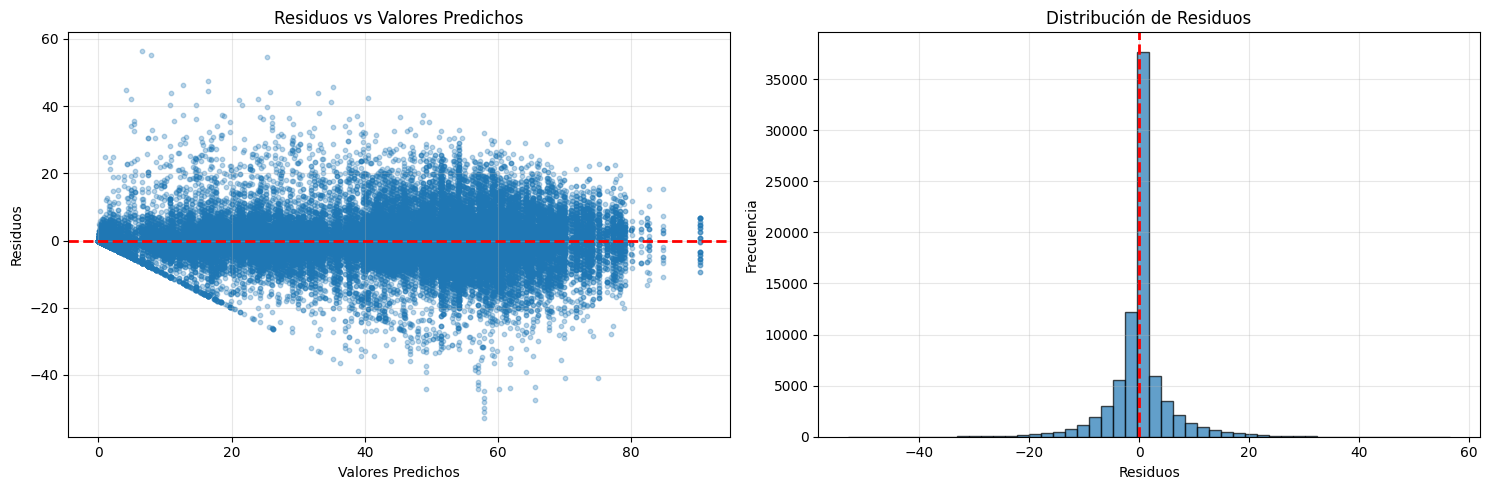

Media de residuos: -0.0000
Desviación estándar de residuos: 5.5388


In [40]:
# Calcular residuos
residuals = y_train - y_train_pred_opt

# Gráfico de residuos
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Residuos vs valores predichos
axes[0].scatter(y_train_pred_opt, residuals, alpha=0.3, s=10)
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Valores Predichos')
axes[0].set_ylabel('Residuos')
axes[0].set_title('Residuos vs Valores Predichos')
axes[0].grid(True, alpha=0.3)

# Histograma de residuos
axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Residuos')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Distribución de Residuos')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Media de residuos: {residuals.mean():.4f}")
print(f"Desviación estándar de residuos: {residuals.std():.4f}")

In [42]:
# Verificar que dt_optimized esté definido
if 'dt_optimized' not in globals():
    raise NameError("Por favor ejecuta primero las celdas que entrenan el modelo optimizado (dt_optimized)")

# Verificar que X_test esté preparado correctamente (sin id ni track_id)
if 'id' in X_test.columns or 'track_id' in X_test.columns:
    print("⚠️ Advertencia: X_test aún contiene columnas 'id' o 'track_id'. Eliminándolas...")
    X_test = X_test.drop(columns=['id', 'track_id'], errors='ignore')

# Asegurar que X_test tenga las mismas columnas que X_train en el mismo orden
X_test = X_test[X_train.columns]

# Generar predicciones para el conjunto de test
y_test_pred = dt_optimized.predict(X_test)

# Crear DataFrame con predicciones (usando 'id' y 'popularity' como requiere el formato)
predictions_df = pd.DataFrame({
    'id': test['id'],
    'popularity': y_test_pred
})

print("Predicciones en TEST:")
print(predictions_df.head(10))
print(f"\nEstadísticas de predicciones:")
print(predictions_df['popularity'].describe())

# Guardar predicciones
predictions_df.to_csv(DATA / 'predictions_decision_tree.csv', index=False)
print(f"\n✅ Predicciones guardadas en: {DATA / 'predictions_decision_tree.csv'}")
print(f"📊 Columnas en el CSV: {predictions_df.columns.tolist()}")
print(f"📊 Shape del CSV: {predictions_df.shape}")

⚠️ Advertencia: X_test aún contiene columnas 'id' o 'track_id'. Eliminándolas...
Predicciones en TEST:
       id  popularity
0  113186   47.558824
1   42819   13.687861
2   59311    0.000000
3   91368    0.012658
4   61000   28.352941
5   96815   39.673469
6   18939   33.125000
7   72760   32.574468
8   25788   38.000000
9   87169   51.225806

Estadísticas de predicciones:
count    34200.000000
mean        31.274964
std         19.216416
min          0.000000
25%         20.181818
50%         32.992481
75%         43.000000
max         90.340909
Name: popularity, dtype: float64

✅ Predicciones guardadas en: c:\Users\alfon\Escritorio\Licenciatura en Sistemas\Machine Learning\Obligatorio\data\predictions_decision_tree.csv
📊 Columnas en el CSV: ['id', 'popularity']
📊 Shape del CSV: (34200, 2)


In [16]:
#Resumen final:

print("\n" + "=" * 80)
print("RESUMEN FINAL - ÁRBOL DE DECISIÓN PARA REGRESIÓN")
print("=" * 80)
print(f"\n DATASET:")
print(f"   - Muestras de entrenamiento: {len(X_train):,}")
print(f"   - Muestras de test: {len(X_test):,}")
print(f"   - Número de features: {X_train.shape[1]}")

print(f"\n MODELO OPTIMIZADO:")
print(f"   - max_depth: {dt_optimized.max_depth}")
print(f"   - min_samples_split: {dt_optimized.min_samples_split}")
print(f"   - min_samples_leaf: {dt_optimized.min_samples_leaf}")
print(f"   - max_features: {dt_optimized.max_features}")
print(f"   - Profundidad real: {dt_optimized.get_depth()}")
print(f"   - Número de hojas: {dt_optimized.get_n_leaves()}")

print(f"\n MÉTRICAS EN TRAIN:")
print(f"   - RMSE: {rmse_train_opt:.4f}")
print(f"   - MAE:  {mae_train_opt:.4f}")
print(f"   - R²:   {r2_train_opt:.4f}")

print(f"\n VALIDACIÓN CRUZADA (5-fold):")
print(f"   - RMSE: {np.sqrt(-grid_search.best_score_):.4f}")

print(f"\n TOP 3 FEATURES:")
for idx, row in feature_importance.head(3).iterrows():
    print(f"   {idx+1}. {row['feature']}: {row['importance']:.4f}")

print("\n" + "=" * 80)


RESUMEN FINAL - ÁRBOL DE DECISIÓN PARA REGRESIÓN

 DATASET:
   - Muestras de entrenamiento: 79,800
   - Muestras de test: 34,200
   - Número de features: 15

 MODELO OPTIMIZADO:
   - max_depth: 20
   - min_samples_split: 50
   - min_samples_leaf: 10
   - max_features: None
   - Profundidad real: 20
   - Número de hojas: 2246

 MÉTRICAS EN TRAIN:
   - RMSE: 5.5388
   - MAE:  2.9946
   - R²:   0.9385

 VALIDACIÓN CRUZADA (5-fold):
   - RMSE: 6.7290

 TOP 3 FEATURES:
   11. album_mean_popularity: 0.9358
   15. genre_mean_popularity: 0.0335
   10. artist_count: 0.0126

